## Um pouco de Teoria

Uma característica padrão de redes neurais é que elas nada mais são do que neurônios densamente conectados que não tem memória. Cada entrada mostrada é processada de forma independente, sem nenhum estado mantido entre a entrada. Com esse tipo de rede, para processar algo sequencial, você tem que mostrar a sequência toda de uma vez, de uma maneira única (O nosso train_scaled). Esse tipo de rede é coinhecida como rede feedfoward.

Contudo, vimos a importância de sequências quando trabalhamos com séries temporais

## Uma arquitetura nova de rede

Uma rede neural recorrente (RNN) adota esse princípio de sequência de uma forma simplificada: ela processa as sequências por meio de uma iteração por meio da sequência de elementos e manter o estado contendo a informação que ele viu. Na verdade, uma RNN nada mais é que uma rede Neural com um loop interno.

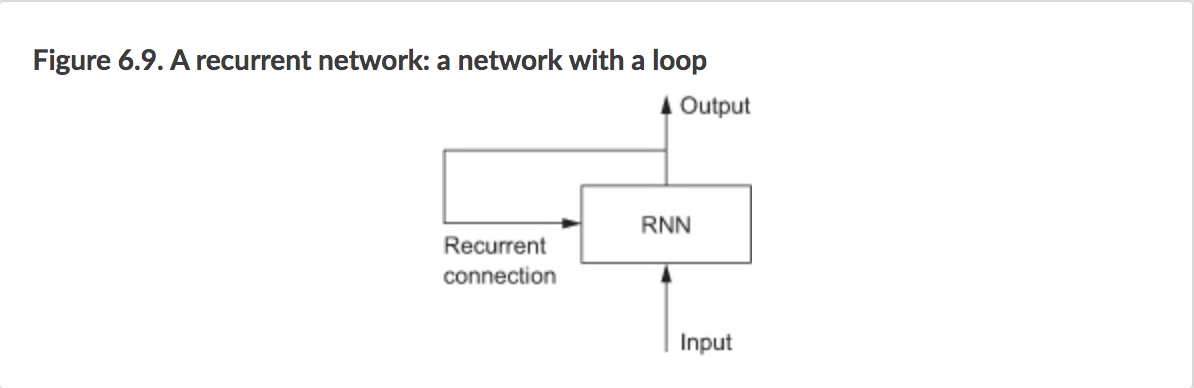

Para ter essa noção de loop e estado, vamos implementar uma RNN no Numpy. Essa RNN recebe como input uma sequência de vetores, que você vai encodar como tensors 2D de tamanho (`timesteps`, `input_features`). Ela irá iterar sobre os timesteps (noção de tempo passando) e a cada `timestep`, ela considera o estado atual `t`, a entrada em `t` (tamanho de (`input_features`,)), e combina eles para ter um output em t. Para o primeiro timestep, a gente não tem o output anterior, então não existe essa noção de `estado atual`. Então, você inicializa o estado como um vetor nulo e chama o estado inicial da rede.

In [1]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    #o que ele ta fazendo é basicamente somando o estado atual com o anterior;  
    #na pratica é como se eu tivesse fazendo duas operações de redes neurais
    #entao pra cada input, eu me baseio na saida anterior pra gerar o output atual
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

    successive_outputs.append(output_t)

    state_t = output_t

final_output_sequence = np.concatenate(successive_outputs, axis=0)

De forma resumida, uma RNN é apenas um for loop que reusa quantidades computadas durante a iteração anterior para o loop atual, nada mais.
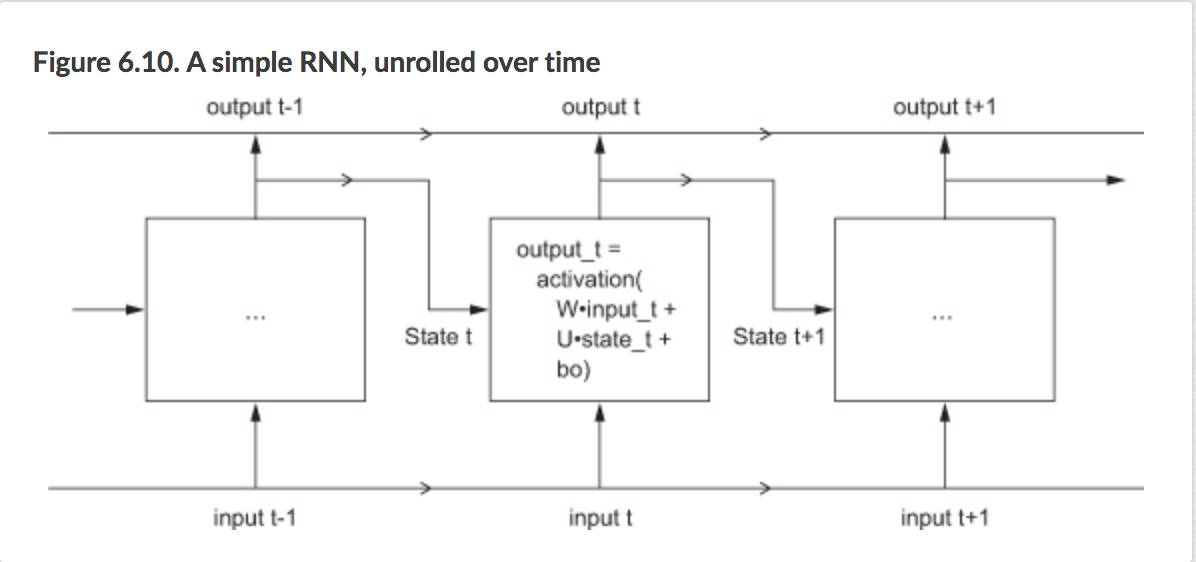

## In Keras

The process you just naively implemented in Numpy corresponds to an actual Keras layer—the SimpleRNN layer

## Mas e no Keras

O processo que você acabou de implementar no Numpy corresponde ao layer `SimpleRNN` do Keras.

Uma outra diferença: a camada `SimpleRNN` processa sequências de `batches`, como todos os outros layers do Keras. Isso significa que ele recebe como input a forma (batch_size, timesteps, input_features), rather than (timesteps, input_features).

In [2]:
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
model = Sequential()
##number of weights(10) + number of bias
#logo, é 32*10 +32=352
##no datacamp só ta passando as features
##Aqui a gente adiciona a timestamp
model.add(Dense(32, input_shape=(100,10)))
#remember input_shape for rnn should receive timesteps and features
##numero de dados de entrada(32)*numero de weights(32)*2(step anterior) + bias
model.add(SimpleRNN(32, return_sequences=False)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100, 32)           352       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


As vezes pode ser interessante empilhar várias camadas recorrentes uma após a outra de forma a aumentar o poder representativo da rede. Nesse tipo de setup, para manter a noção de sequência, você precisa fazer com que os layers intermediários retornem toda a sequência de output.

In [4]:
model = Sequential()
model.add(Dense(32, input_shape=(100,10)))
model.add(SimpleRNN(32, return_sequences=True)) #precisamos salvar a swquencia para alimentar a proxima
model.add(SimpleRNN(32, return_sequences=True)) 
model.add(SimpleRNN(32, return_sequences=True)) 
model.add(SimpleRNN(32)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100, 32)           352       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 32)           2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 32)           2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100, 32)           2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 8,672
Trainable params: 8,672
Non-trainable params: 0
_________________________________________________________________


## The Vanishing Gradient Problem

Como é possível ver, o simples uso dessa camada de recorrência acaba por incluir muitos parâmetros. Isso gera um problema: apesar das RNN poderem, teoricamente, ter essa noção de armazenamentono momento `t` sobre aquilo que aconteceu vários `timesteps` atrás, na prática, dependencias a longo prazo são impossíveis de aprender. Isso acontece por conta do vanishing gradient problem (vocês viram no datacamp). Isso também ocorre em redes feedfoward com muitas camadas: conforme você adiciona mais camadas, a rede como um todo fica intreinável por conta dos gradientes, que acabam por anular ou explodir os pesos.

Uma abordagem para esse problema são as chamadas LSTM

## Long Short Term Memory

#### A criação do conceito de "memória"

Essa camada é um variante das SimpleRNN que já vimos. Ela adiciona uma forma de carregar informação dentre vários timesteps. Imagine como uma correia transportadora correndo em paralelo à sequência que você está processando. A informação da sequência pode "pular" por meio dessa correia para qualquer ponto, sendo transportada para um ponto mais tarde no tempo (e, de fato, pula) quando você precisa. Isso é basicamente o que a LSTM faz: ela salva informações para mais tarde prevenindo, então, de sinais anteriores de sofrerem do vanishing problem.

Para entender isso com detalhes, vamos começar com uma célula SimpleRNN. Porquê você terá uma série de matrizes, vamos indexar as matrizes W e U na celula com a letra o (Wo and Uo) para output.

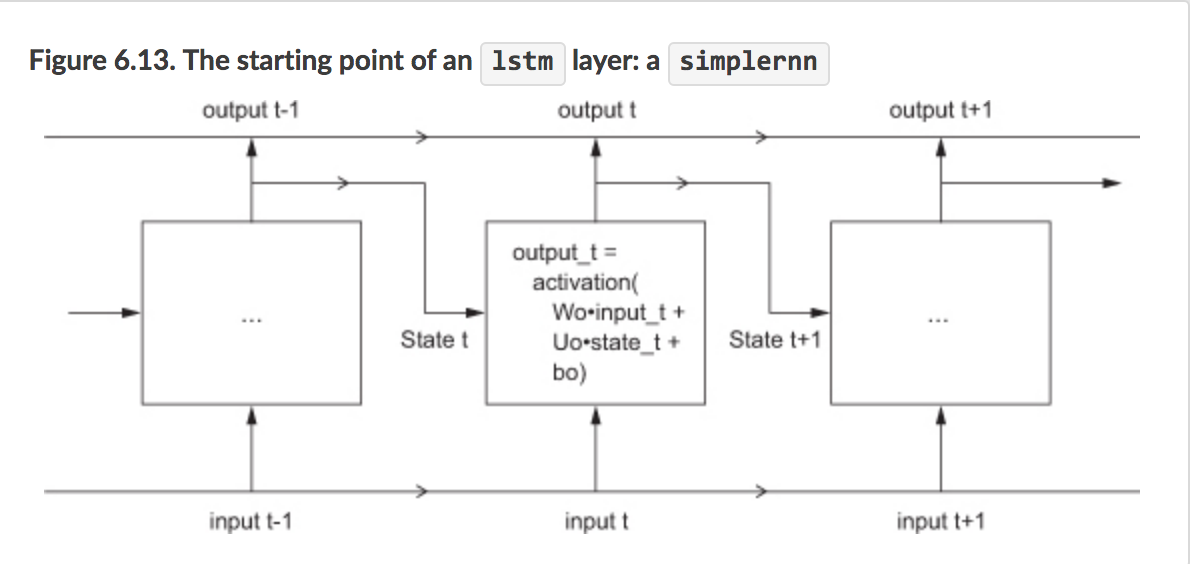

Vamos adicionar essa imagem ao dataflow original que carrega informação entre vários timesteps. Vamos chamar esses valores de Ct, em que C significa Carry. Essa informação terá o seguinte impacto na célula: ela será combinada com diferentes inputs da camada de entrada e a conexão de recorrência (por meio de um dot product adicionado com o bias), e irá afetar no estado da matriz sendo enviada ao próximo timestep. Conceitualmente, esse dataflow de carregamento é uma forma de modular o próximo output do próximo estado.
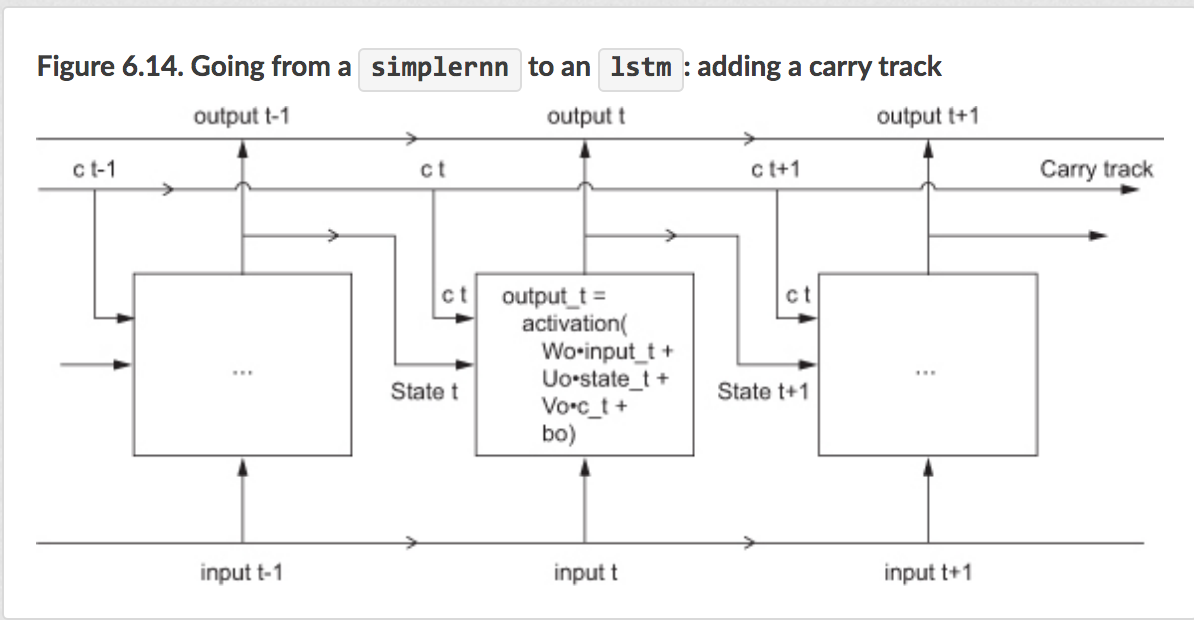

### Now, the tricky part

Now the subtlety: the way the next value of the carry dataflow is computed. It involves three distinct transformations. 


```
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

```

```
c_t+1 = i_t * k_t + c_t * f_t
```
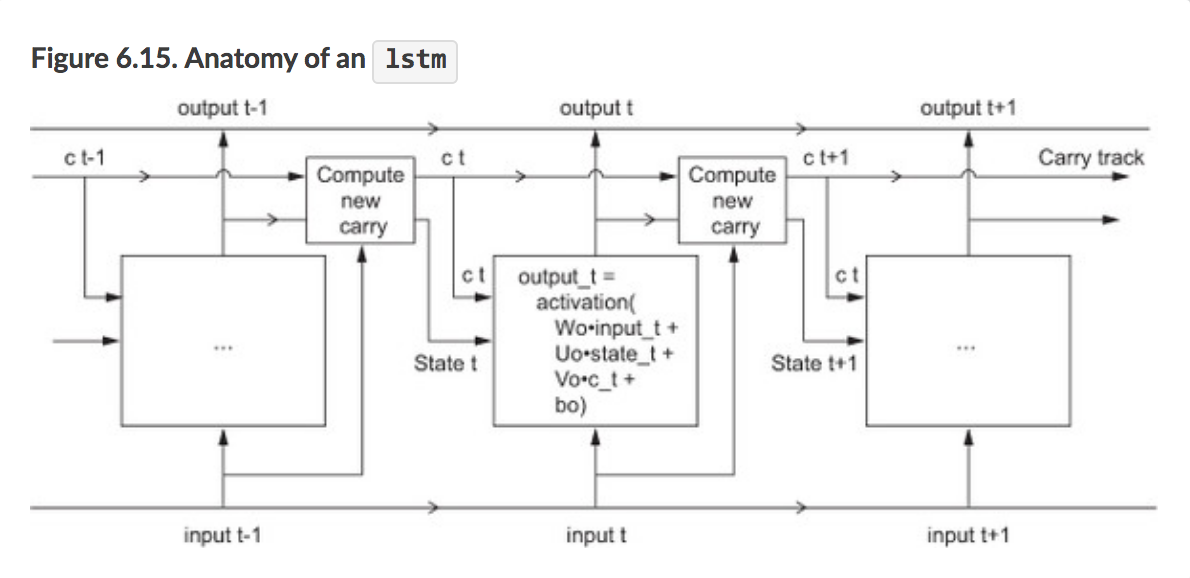

## But what does that mean

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying c_t and f_t is a way to deliberately forget irrelevant information in the carry dataflow (porque com o passar do tempo esses caras que vao sendo reduzidos pelo gradiente?). Meanwhile, i_t and k_t provide information about the present, updating the carry track with new information. But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines your hypothesis space—the space in which you’ll search for a good model configuration during training—but it doesn’t determine what the cell does; that is up to the cell weights. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.

To a researcher, it seems that the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. And in the future, that’s how we’ll build networks. In summary: you don’t need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn’t be your job to understand it. Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in tqdm(range(nb_epoch)):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('../data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()